# From shapefile to TopoJSON

This notebook replicates the work done with the GeoJSON files but using shapefiles (.shp) that can be downloaded from the DANE's website: [Descarga de datos geoestadísticos](https://geoportal.dane.gov.co/servicios/descarga-y-metadatos/datos-geoestadisticos/?cod=111). It seems the shapefiles are updated more frequently than the GeoJSON files. The shapefiles used in this notebook are:

- Departments: **Versión MGN2022-Nivel Departamento**
- Towns: **Versión MGN2022-Nivel Municipio**

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import shapely

# We tell pandas we wanna see all the columns from the DataFrames
pd.set_option('display.max_columns', None)

## 1. Departments

### 1.1. Exploration

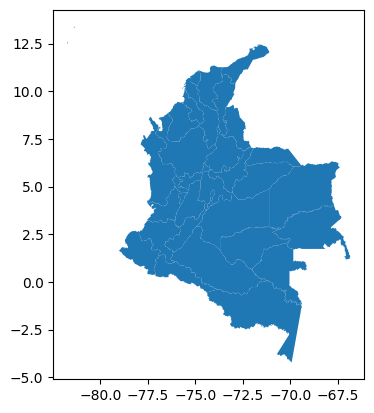

In [3]:
# Load the shapefile using geopandas
departments = gpd.read_file('departamentos/MGN_DPTO_POLITICO.shp')

# Plot the shapefile
departments.plot()
plt.show()

In [4]:
departments.head(2)

,DPTO_CCDGO,DPTO_CNMBR,DPTO_ANO_C,DPTO_ACT_A,DPTO_NAREA,DPTO_CSMBL,DPTO_VGNC,Shape_Leng,Shape_Area,geometry
0,97,VAUPÉS,1991,Articulo 309 Constitucion Politica de 1991,53299.280015,3,2022,20.129834,4.313810,"POLYGON ((-70.11033 2.08010, -70.10981 2.08002..."
1,05,ANTIOQUIA,1886,Constitucion Politica de 1886,62808.749579,3,2022,21.490700,5.135246,"POLYGON ((-76.41355 8.87383, -76.40465 8.85195..."


We create the boolean condition to extract the archipelago's info.

In [5]:
condition = departments['DPTO_CCDGO'] == '88'

We extract the archipelago's polygons and plot them as they come in the shapefile.

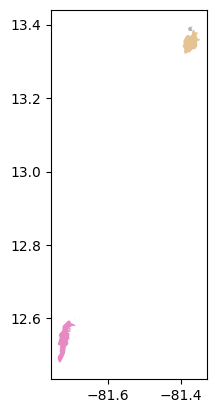

In [6]:
polys = list(shapely.ops.polygonize(departments.loc[condition, 'geometry']))
polys = gpd.GeoSeries(polys)
polys.plot(cmap = 'Set2')
plt.show()

We check how many polygons the archipelago has.

In [7]:
print("Archipelago's polygons: " + str(len(polys)))

Archipelago's polygons: 6


### 1.2. 'Internal' shifting

We split the archipelago into two multipolygons:

- San Andrés (and three small surrounding islands)
- Providencia (and Santa Catalina)

In [8]:
polygon_list = []
for i in range(len(polys)):
    polygon_list.append(gpd.GeoSeries(polys[i]))

san_andres = Polygon()
san_andres = san_andres.union(polygon_list[0]).union(polygon_list[1]).union(polygon_list[2]).union(polygon_list[3])
providencia = Polygon()
providencia = providencia.union(polygon_list[4]).union(polygon_list[5])

From the departments work using a departments GeoJSON and the way we shifted San Andrés, we know we need to add some space between San Andrés and Providencia when shifting San Andrés toward Providencia. In the shifting, we make San Andrés to overlap with Providencia since we make their westernmost points to overlap. We substract 1.5 times San Andrés' size (in the $x$ axis) from the shifting amount.

In [9]:
space = (polygon_list[2].bounds['minx']*-1)-(polygon_list[2].bounds['maxx']*-1)
space = space.values[0]*1.5

We perform the shifting.

**Note:** in the $x$ coordinate, positive values shift stuff from west to east (left to right) while negative values shift stuff from east to west (right to left). In the $y$ coordinate, positive values shift stuff from south to north while negative values shift stuff from north to south.

In [10]:
san_andres_y = san_andres.bounds['maxy']
ref_y = providencia.bounds['maxy']
y_offset = (ref_y - san_andres_y) # A positive value shifts San Andrés toward the north
y_offset = y_offset.values[0]

san_andres_x = san_andres.bounds['minx']
ref_x = providencia.bounds['minx']
x_offset = (san_andres_x - ref_x)*-1 # A positive value shifts San Andrés toward the east
x_offset = x_offset.values[0] - space

san_andres = san_andres.translate(xoff = x_offset, yoff = y_offset)

We bring the whole archipelago back together.

In [11]:
san_andres_polys = list(shapely.ops.polygonize(san_andres))
san_andres_list = []
for i in range(len(san_andres_polys)):
    san_andres_list.append(gpd.GeoSeries(san_andres_polys[i]))

providencia_polys = list(shapely.ops.polygonize(providencia))
providencia_list = []
for i in range(len(providencia_polys)):
    providencia_list.append(gpd.GeoSeries(providencia_polys[i]))

polygon_list[0] = san_andres_list[0]
polygon_list[1] = san_andres_list[1]
polygon_list[2] = san_andres_list[2]
polygon_list[3] = san_andres_list[3]
polygon_list[4] = providencia_list[0]
polygon_list[5] = providencia_list[1]

new_multipolygon = Polygon()
for polygon in polygon_list:
    new_multipolygon = new_multipolygon.union(polygon)

departments.loc[condition, 'geometry'] = new_multipolygon.values[0]

### 1.3. Size increase

We increase the size of the whole archipelago.

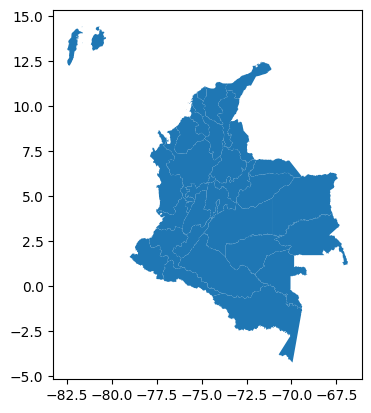

In [12]:
departments.loc[condition, 'geometry'] = \
    departments.loc[condition, 'geometry'].scale(xfact = 18, yfact = 18, origin = 'center')

### 1.4. Archipelago shifting

We shift the whole archipelago toward the east (reference point: mainland's westernmost point) and the south (reference point: mainland's northernmost point) and visually check the final result.

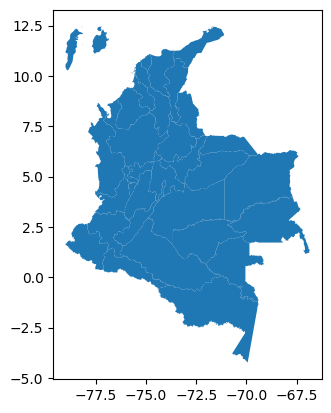

In [13]:
archipelago_y = departments.loc[condition, 'geometry'].bounds['maxy']
ref_y = departments.loc[~condition, 'geometry'].bounds['maxy'].max()
y_offset = (archipelago_y - ref_y)*-1 # A negative value shifts the archipelago toward the south
y_offset = y_offset.values[0]

archipelago_x = departments.loc[condition, 'geometry'].bounds['minx']
ref_x = departments.loc[~condition, 'geometry'].bounds['minx'].min()
x_offset = (archipelago_x - ref_x)*-1 # A positive value shifts the archipelago toward the east
x_offset = x_offset.values[0]

departments.loc[condition, 'geometry'] = departments.loc[condition, 'geometry'].translate(xoff = x_offset, \
                                                                                          yoff = y_offset)
departments.plot()
plt.show()

We save the shifting reference we use to shift Providencia when working with the towns shapefile.

In [14]:
polys = list(shapely.ops.polygonize(departments.loc[condition, 'geometry']))
polygon_list = []
for i in range(len(polys)):
    polygon_list.append(gpd.GeoSeries(polys[i]))

town_x_reference = polygon_list[4].bounds['minx']
town_x_reference.to_csv('municipios/town_x_reference.csv', index = False)

### 1.5. Final processing

We perform some final esthetic processing.

In [15]:
column_list = [1, 2, 3, 4, 5, 6, 7, 8]
departments.drop(departments.columns[column_list], axis = 1, inplace = True)
departments.rename(columns = {'DPTO_CCDGO': 'codigo_departamento_s'}, inplace = True)
departments['codigo_departamento_n'] = departments['codigo_departamento_s'].astype(int)
series = departments['geometry']
departments.drop('geometry', axis = 1, inplace = True)
departments['geometry'] = series
departments.head()

,codigo_departamento_s,codigo_departamento_n,geometry
0,97,97,"POLYGON ((-70.11033 2.08010, -70.10981 2.08002..."
1,05,5,"POLYGON ((-76.41355 8.87383, -76.40465 8.85195..."
2,08,8,"POLYGON ((-74.84946 11.09778, -74.84938 11.097..."
3,11,11,"POLYGON ((-74.07059 4.82856, -74.07036 4.82856..."
4,13,13,"MULTIPOLYGON (((-76.17318 9.38785, -76.17287 9..."


### 1.6. TopoJSON conversion

We save the GeoDataFrame in a GeoJSON format.

In [16]:
departments.to_file('departamentos/MGN_DPTO_POLITICO_rJAC.geoJSON', driver = 'GeoJSON')

The final step is to convert the GeoJSON file to a TopoJSON format: 

```bash
geo2topo -q 1e4 MGN_DPTO_POLITICO_rJAC.geojson > mapa_departamentos.json
```

You can also get a file of reduced size (and quality) by changing the quantization parameter:

```bash
geo2topo -q 1e3 MGN_DPTO_POLITICO_rJAC.geojson > mapa_departamentos_q3.json
```

Below there's a screenshot of how the TopoJSON map looks like in a Power BI dashboard. The TopoJSON was obtained with the second bash command above.

![dashboard](./../images/dashboard_departments_r2.png)

## 2. Towns

### 2.1. Exploration

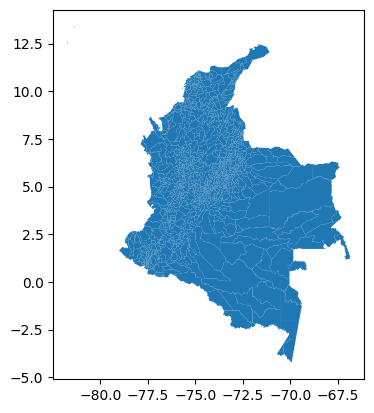

In [17]:
# Load the shapefile using geopandas
towns = gpd.read_file('municipios/MGN_MPIO_POLITICO.shp')

# Plot the shapefile
towns.plot()
plt.show()

In [18]:
towns.head(2)

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CDPMP,DPTO_CNMBR,MPIO_CNMBR,MPIO_CRSLC,MPIO_NAREA,MPIO_CSMBL,MPIO_VGNC,MPIO_TIPO,Shape_Leng,Shape_Area,geometry
0,97,001,97001,VAUPÉS,MITÚ,Decreto Nal 1666 del 6 de Agosto de 1974,16215.737264,4,2022,MUNICIPIO,6.352591,1.312171,"POLYGON ((-70.41904 1.77173, -70.41723 1.77150..."
1,97,161,97161,VAUPÉS,CARURÚ,Ordenanza 003 del 7 de Agosto de 1993,6368.486418,4,2022,MUNICIPIO,4.618318,0.516272,"POLYGON ((-71.36685 1.73621, -71.36728 1.73566..."


We create the boolean conditions to extract the towns info.

In [19]:
condition_s = towns['MPIO_CDPMP'] == '88001' # San Andrés
condition_p = towns['MPIO_CDPMP'] == '88564' # Providencia

### 2.2. Size increae

We increae the size of both towns.

In [20]:
towns.loc[condition_s, 'geometry'] = \
    towns.loc[condition_s, 'geometry'].scale(xfact = 18, yfact = 18, origin = 'center')
towns.loc[condition_p, 'geometry'] = \
    towns.loc[condition_p, 'geometry'].scale(xfact = 18, yfact = 18, origin = 'center')

### 2.3. Shifting

We shift San Andrés toward the south (reference point: mainland's northernmost point) and the east (reference point: mainland's westernmost point).

In [21]:
san_andres_x = towns.loc[condition_s, 'geometry'].bounds['minx']
ref_x = towns.loc[(~condition_s) & (~condition_p), 'geometry'].bounds['minx'].min()
x_offset = (san_andres_x - ref_x)*-1
x_offset = x_offset.values[0]

san_andres_y = towns.loc[condition_s, 'geometry'].bounds['maxy']
ref_y = towns.loc[(~condition_s) & (~condition_p), 'geometry'].bounds['maxy'].max()
y_offset = (san_andres_y - ref_y)*-1
y_offset = y_offset.values[0]

towns.loc[condition_s, 'geometry'] = towns.loc[condition_s, 'geometry'].translate(xoff = x_offset, \
                                                                                  yoff = y_offset)

We shift Providencia toward the south (reference point: San Andrés' northernmost point after shifted) and the east (reference point: Providencia's westernmost point after shifted during the deparments work) and visually check the final result.

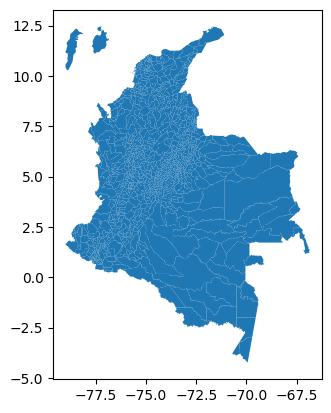

In [22]:
providencia_x = towns.loc[condition_p, 'geometry'].bounds['minx']
town_x_reference = pd.read_csv('municipios/town_x_reference.csv').iloc[0, 0]
x_offset = (providencia_x.values[0] - town_x_reference)*-1

providencia_y = towns.loc[condition_p, 'geometry'].bounds['maxy']
ref_y = towns.loc[condition_s, 'geometry'].bounds['maxy'].max()
y_offset = (providencia_y - ref_y)*-1
y_offset = y_offset.values[0]

towns.loc[condition_p, 'geometry'] = towns.loc[condition_p, 'geometry'].translate(xoff = x_offset, \
                                                                                  yoff = y_offset)
towns.plot()
plt.show()

### 2.4. Final processing

We perform some final esthetic processing.

In [23]:
column_list = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11]
towns.drop(towns.columns[column_list], axis = 1, inplace = True)
towns.rename(columns = {'MPIO_CDPMP': 'codigo_municipio_s'}, inplace = True)
towns['codigo_municipio_n'] = towns['codigo_municipio_s'].astype(int)
series = towns['geometry']
towns.drop('geometry', axis = 1, inplace = True)
towns['geometry'] = series
towns.head()

,codigo_municipio_s,codigo_municipio_n,geometry
0,97001,97001,"POLYGON ((-70.41904 1.77173, -70.41723 1.77150..."
1,97161,97161,"POLYGON ((-71.36685 1.73621, -71.36728 1.73566..."
2,97511,97511,"POLYGON ((-71.57715 0.68364, -71.55278 0.66162..."
3,97666,97666,"POLYGON ((-70.05217 -0.14663, -70.05228 -0.146..."
4,97777,97777,"POLYGON ((-70.11033 2.08010, -70.10981 2.08002..."


### 2.5. TopoJSON conversion

We save the GeoDataFrame in a GeoJSON format.

In [24]:
towns.to_file('municipios/MGN_MPIO_POLITICO_rJAC.geoJSON', driver = 'GeoJSON')

The final step is to convert the GeoJSON file to a TopoJSON format: 

```bash
geo2topo -q 1e4 MGN_MPIO_POLITICO_rJAC.geojson > mapa_municipios.json
```

Or try with a lower quality conversion:

```bash
geo2topo -q 1e3 MGN_MPIO_POLITICO_rJAC.geojson > mapa_municipios_q3.json
```

Below there's a screenshot of how the TopoJSON map looks like in a Power BI dashboard. The TopoJSON was obtained with the second bash command above.

![dashboard](./../images/dashboard_towns_r.png)